In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/realwaste/realwaste-main/README.md
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_670.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_408.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_222.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_200.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_533.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_7.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_285.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_210.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_243.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_590.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_214.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_455.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/Metal_622.jpg
/kaggle/input/realwaste/realwaste-main/RealWaste/Metal/M

## Import Library

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image # Pemrosesan Gambar
import os
import pandas as pd
import matplotlib.pyplot as plt # Visualisasi Data
import numpy as np # Operasi aljabar linear
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load Data and Preprocessing

In [3]:
imdir = '/kaggle/input/realwaste/realwaste-main/RealWaste'
image_aug = transforms.Compose(
   [ 
    transforms.RandomVerticalFlip(p=0.3),
    # transforms.ColorJitter(brightness=(0.5,1,0.5), contrast=(1), saturation=(0.5,1,5), hue=(-0.1,-0.1)),
    transforms.RandomRotation(degrees=0.2),
    transforms.RandomCrop(size=(224,234)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   ]
)

dataset = ImageFolder(root=imdir, transform=image_aug)

In [4]:
dataset[122][0].shape

torch.Size([3, 224, 234])

In [5]:
os.listdir(imdir)

['Metal',
 'Glass',
 'Paper',
 'Vegetation',
 'Cardboard',
 'Textile Trash',
 'Food Organics',
 'Plastic',
 'Miscellaneous Trash']

## Data Splitting

In [6]:
# Calculate split sizes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Costructing Data Loader

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=4, shuffle=True)

## Model Building

In [10]:
class FeatureExtractor(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=3, padding=1):
        super(FeatureExtractor, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.conv = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=self.kernel_size, stride=self.kernel_size, padding=self.padding)
        self.bn = nn.BatchNorm2d(self.out_channels)
        self.act = nn.SiLU()
        self.maxpool = nn.MaxPool2d(2, stride=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.maxpool(x)
        return x

class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, residual_type=0):
        super(ConvolutionalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self.out_channels)
        self.act = nn.SiLU()
        self.conv2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self.out_channels)

        self.residual_type = residual_type
        
        if residual_type == "with_conv":
            self.skip_conv = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=3, stride=1, padding=1)
        else:
            self.skip_conv = nn.Identity()
        
    def forward(self, x):
        res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.residual_type != "no_residual":
            x = x + self.skip_conv(res)
        x = self.act(x)
        return x
    
class SAM(nn.Module):
    def __init__(self, bias=False):
        super(SAM, self).__init__()
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, dilation=1, bias=self.bias)

    def forward(self, x):
        max = torch.max(x,1)[0].unsqueeze(1)
        avg = torch.mean(x,1).unsqueeze(1)
        concat = torch.cat((max,avg), dim=1)
        output = self.conv(concat)
        output = output * x
        return output

class CAM(nn.Module):
    def __init__(self, channels, r):
        super(CAM, self).__init__()
        self.channels = channels
        self.r = r
        self.linear_max = nn.Sequential(
            nn.Linear(in_features=self.channels, out_features=self.channels//self.r, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.channels//self.r, out_features=self.channels, bias=True))

    def forward(self, x):
        max = F.adaptive_max_pool2d(x, output_size=1)
        avg = F.adaptive_avg_pool2d(x, output_size=1)
        b, c, _, _ = x.size()
        linear_max = self.linear(max.view(b,c)).view(b, c, 1, 1)
        linear_avg = self.linear(avg.view(b,c)).view(b, c, 1, 1)
        output = linear_max + linear_avg
        output = F.sigmoid(output) * x
        return output

class CBAM(nn.Module):
    def __init__(self, channels, r):
        super(CBAM, self).__init__()
        self.channels = channels
        self.r = r
        self.sam = SAM(bias=False)
        self.cam = CAM(channels=self.channels, r=self.r)

    def forward(self, x):
        output = self.cam(x)
        output = self.sam(output)
        return output + x


def conv_block(in_channels, out_channels):
    return nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())

class VGG19(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block1 = nn.Sequential(nn.Conv2d(in_channels=self.in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         conv_block(64, 64),
                                         CBAM(64, r=2),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         conv_block(128, 128),
                                         CBAM(128, r=2),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(256),
                                         nn.ReLU(),
                                         *[conv_block(256, 256) for _ in range(3)],
                                         CBAM(256, r=2),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block4 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
                                         nn.BatchNorm2d(512),
                                         nn.ReLU(),
                                         *[conv_block(512, 512) for _ in range(3)],
                                         CBAM(512, r=2),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.conv_block5 = nn.Sequential(*[conv_block(512, 512) for _ in range(4)],
                                         CBAM(512, r=2),
                                         nn.MaxPool2d(kernel_size=2, stride=2))

        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(7,7))

        self.linear1 = nn.Sequential(nn.Linear(in_features=7*7*512, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear2 = nn.Sequential(nn.Linear(in_features=4096, out_features=4096, bias=True),
                                     nn.Dropout(0.5),
                                     nn.ReLU())
        self.linear3 = nn.Linear(in_features=4096, out_features=self.out_channels, bias=True)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.avg_pool(x)
        x = self.linear1(x.view(x.shape[0], -1))
        x = self.linear2(x)
        x = self.linear3(x)
        return x

class MetaResNetCBAM7(nn.Module):
    def __init__(self, in_channels, out_channels, num_ffn, dropout=0.3):
        super(MetaResNetCBAM7, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_ffn = num_ffn
        self.dropout = dropout 

        self.feature_extractor = FeatureExtractor(self.in_channels, self.out_channels, kernel_size=7, stride=3, padding=1)
        self.bottleneck = nn.Sequential(
            ConvolutionalBlock(self.out_channels, self.out_channels*2, residual_type="with_conv"),
            ConvolutionalBlock(self.out_channels*2, self.out_channels*2, residual_type="no_residual"),
            ConvolutionalBlock(self.out_channels*2, self.out_channels*2, residual_type="no_residual"),
            # ConvolutionalBlock(self.out_channels*2, self.out_channels*2, residual_type="no_residual"),
            ConvolutionalBlock(self.out_channels*2, self.out_channels*2, residual_type="no_residual"),
            ConvolutionalBlock(self.out_channels*2, self.out_channels*4, residual_type="with_conv")
        )
        self.cbam = VGG19(self.in_channels, self.out_channels)
        self.ffn = nn.Sequential(
            nn.Linear(256, self.num_ffn),
            nn.ReLU(),
            nn.Linear(self.num_ffn, 256)
        )
        self.classifier = nn.Linear(256, 9)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.bottleneck(x)
        x = torch.mean(x, dim=(2, 3))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = torch.mean(x, dim=(2, 3))  # Reduce spatial dimensions
        x = x.view(x.size(0), -1)      # Flatten to [batch_size, features]
        x = self.ffn(x)
        x = self.classifier(x)
        # x = self.softmax(x)
        return x

In [11]:
sample_in = torch.randn(1, 3, 224, 224)
sample_model = MetaResNetCBAM7(3, 64, 256)

In [10]:
sample_model(torch.randn(1, 3, 224, 224))

tensor([[-0.0329,  0.0104, -0.0765,  0.0013, -0.0334, -0.0621,  0.0656, -0.0699,
         -0.0182]], grad_fn=<AddmmBackward0>)

## Training and Evaluation Loop

In [12]:
loss_fn = nn.CrossEntropyLoss() 
model = MetaResNetCBAM7(3, 64, 256)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

def train_model(model, train_loader, val_loader, epochs=10, device='cuda'):
    model = model.to(device)
    best_val_loss = float('inf')
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = loss_fn(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

                # Compute accuracy
                _, predicted = outputs.max(1)  # Get class with max probability
                correct += (predicted == targets).sum().item()
                total += targets.size(0)

        val_loss /= len(val_loader.dataset)
        accuracy = correct / total

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saved!")

# Evaluation loop
def evaluate_model(model, data_loader, device='cuda'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    print(f"Evaluation Accuracy: {accuracy:.4f}")

# Assuming `train_loader` and `val_loader` are defined
train_model(model, train_loader, val_loader, epochs=100)

Epoch 1/100
Train Loss: 1.9631
Validation Loss: 1.8202, Accuracy: 0.3260
Model saved!
Epoch 2/100
Train Loss: 1.8411
Validation Loss: 1.7721, Accuracy: 0.3091
Model saved!
Epoch 3/100
Train Loss: 1.7855
Validation Loss: 1.7733, Accuracy: 0.3417
Epoch 4/100
Train Loss: 1.7284
Validation Loss: 1.7466, Accuracy: 0.3775
Model saved!
Epoch 5/100
Train Loss: 1.6752
Validation Loss: 1.8203, Accuracy: 0.3481
Epoch 6/100
Train Loss: 1.6545
Validation Loss: 1.5915, Accuracy: 0.4132
Model saved!
Epoch 7/100
Train Loss: 1.6232
Validation Loss: 1.5631, Accuracy: 0.4374
Model saved!
Epoch 8/100
Train Loss: 1.6038
Validation Loss: 1.5651, Accuracy: 0.4248
Epoch 9/100
Train Loss: 1.5396
Validation Loss: 1.4481, Accuracy: 0.4774
Model saved!
Epoch 10/100
Train Loss: 1.5238
Validation Loss: 1.5390, Accuracy: 0.4448
Epoch 11/100
Train Loss: 1.4979
Validation Loss: 1.5011, Accuracy: 0.4416
Epoch 12/100
Train Loss: 1.4571
Validation Loss: 1.3765, Accuracy: 0.4953
Model saved!
Epoch 13/100
Train Loss: 1.414

In [13]:
model = MetaResNetCBAM7(3, 64, 256).to("cuda")
model.load_state_dict(torch.load("/kaggle/working/best_model.pth", weights_only=True))

<All keys matched successfully>

In [14]:
def model_reporting(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    conf_matrix = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    class_report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

    print("\nClassification Report:\n")
    print(class_report)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


Classification Report:

                     precision    recall  f1-score   support

          Cardboard     0.7545    0.8646    0.8058        96
      Food Organics     0.6549    0.9250    0.7668        80
              Glass     0.8143    0.7403    0.7755        77
              Metal     0.7183    0.6986    0.7083       146
Miscellaneous Trash     0.5625    0.5745    0.5684        94
              Paper     0.8119    0.6949    0.7489       118
            Plastic     0.7821    0.6816    0.7284       179
      Textile Trash     0.6129    0.6667    0.6387        57
         Vegetation     0.9010    0.8750    0.8878       104

           accuracy                         0.7392       951
          macro avg     0.7347    0.7468    0.7365       951
       weighted avg     0.7463    0.7392    0.7390       951



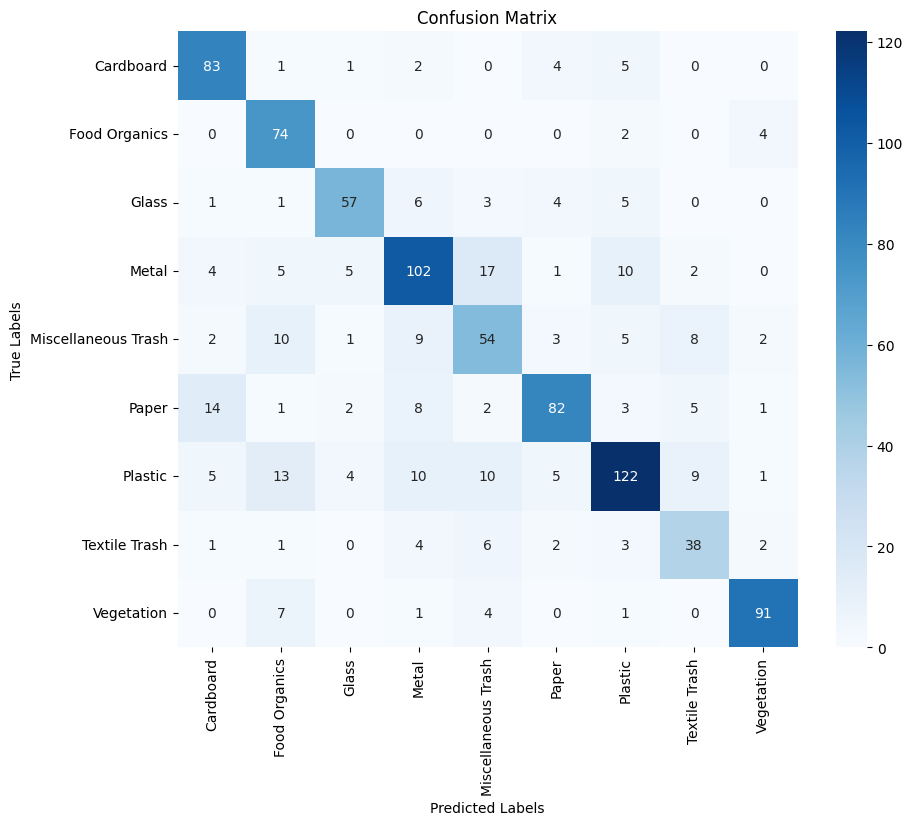

In [15]:
model_reporting(model, val_loader, device="cuda", class_names=dataset.classes)